# Simple RL code to teach the model to stand

## Setup jax enviroment and Load Model 

In [1]:
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt

import sys
sys.path.append("../Biodiffrl")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".80"

# Optionally, force JAX to preallocate memory.
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Setup environment variable for Nvidia GPU acceleration
os.environ['XLA_FLAGS'] = (
    # '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    # '--xla_gpu_enable_async_collectives=true '
    # '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
    # '--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=32'
)

backend = 'gpu'
# backend = 'METAL'
# backend = 'cpu'

import jax
jax.config.update('jax_platform_name', 'gpu')
# os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_lazy_compilation=false"
# Enable compliation catch
os.environ["JAX_COMPILATION_CACHE_DIR"] = "./jax_cache"
jax.config.update("jax_compilation_cache_dir", "./jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", 0)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 2)
# jax.config.update("jax_explain_cache_misses", True)

from jax.experimental.compilation_cache import compilation_cache as cc
cc.set_cache_dir("./jax_cache")
# Debug Nan
# jax.config.update("jax_debug_nans", True)

from jax import numpy as jp
# More legible printing from numpy.
jp.set_printoptions(precision=4, suppress=True, linewidth=100)

import mujoco
import mujoco.mjx as mjx
from mujoco.mjx._src import scan
from mujoco.mjx._src import types

# More legible printing from numpy.
np.set_printoptions(precision=4, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

device = jax.devices(backend=backend)[0]

model_path = '/home/bugman/Currentwork/biomujoco_converter/converted/mjc/Gait2354/gait2354_cvt1.xml'

# Single step
mjx_step = jax.jit(mjx.step, backend=backend)



# mjx_multiple_steps = jax.jit(multiple_steps, backend=backend, )

## Load Model

In [2]:
from mujoco.mjx._src.biomtu import acceleration_mtu

mj_model = mujoco.MjModel.from_xml_path(model_path)
mjx_model = mjx.put_model(mj_model,device=device)

# Disable tendon
opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)
mjx_data = jax.jit(mjx_step)(mjx_model, mjx_data)

init_mjx_data = mjx_data

def print_all():
    print(mjx_model.biomtu_adr)
    print(mjx_model.mtu_wrap_objid)
    print(mjx_model.mtu_wrap_type)
    print(mjx_model.biomtu_fiso)
    print(mjx_model.biomtu_vmax)
    print(mjx_model.biomtu_ofl)
    print(mjx_model.biomtu_opa)
    print(mjx_model.biomtu_mass)
    print("-------Data--------")
    print("qpos:", mjx_data.qpos)
    print("mtu l:", mjx_data.biomtu.l)
    print("tendon l:", mjx_data.biomtu.tendon_l)
    print("fiber l :", mjx_data.biomtu.fiber_l)
    print("Muscle Bce:", mjx_data.biomtu.B_ce)
    print("Muscle vm:", mjx_data.biomtu.m)
    print("Fiber acc:", mjx_data.biomtu.fiber_acc)
    print("Fiber v:", mjx_data.biomtu.fiber_v)
    print("Biomtu h:", mjx_data.biomtu.h)
    print(mjx_data.biomtu.v)
    print(mjx_data.biomtu.h)  # The constant high of the muscle.
    print(mjx_data.biomtu.pennation_angle)
    print(mjx_data.biomtu.origin_body_id)
    print(mjx_data.biomtu.insertion_body_id)
    print("mtu act:", mjx_data.biomtu.act)
    # print(mjx_data.biomtu.j)
    print(mjx_data.qfrc_biomtu)
    print(mj_model.key_time)
    print(mj_model.key_qpos)
    print(mj_model.key_qvel)

# print_all()

print(mjx_model.nbiomtu)
print(mjx_model.nq)
print(mjx_data.qpos)
print(mjx_data.qvel)

54
27
[ 0.      0.9501  0.      0.0006  0.     -0.     -0.0013 -0.     -0.0009 -0.0037 -0.3957  0.0023
 -0.0199 -0.0032  0.0228 -0.0013 -0.     -0.0009 -0.0037 -0.3957  0.0023 -0.0199 -0.0032  0.0228
 -0.0007 -0.      0.    ]
[ 0.0149  0.0271  0.      0.3064  0.     -0.     -0.6693 -0.0194 -0.4365 -0.0074  0.0056  1.1327
 -9.9627 -1.625  11.377  -0.6693 -0.0194 -0.4365 -0.0074  0.0056  1.1327 -9.9628 -1.625  11.377
 -0.3256 -0.      0.    ]


## Neural Networks

In [3]:
import nn

key = jax.random.key(2024)
# Controller NN
controller_nn = nn.Controller_NN(mjx_model.nq*2+mjx_model.nbiomtu*2, mjx_model.nbiomtu)
controller_params, key = controller_nn.init_parameters(key)
controller = controller_nn.get_fn()

# Critic NN
critic_nn = nn.Critic_NN(mjx_model.nq*2 + mjx_model.nbiomtu*2,1)
critic_params, key = critic_nn.init_parameters(key)
criticer = critic_nn.get_fn()

# Test the two neural networks
controller_output = controller(controller_params, jp.ones(mjx_model.nq*2+mjx_model.nbiomtu*2), key)
print(controller_output[0].shape)
print(controller_output)
print(criticer(critic_params, jp.ones(mjx_model.nq*2+mjx_model.nbiomtu*2)))

(54,)
(Array([0.    , 0.    , 1.0761, 0.1984, 1.1329, 0.    , 1.8726, 0.0723, 0.4445, 0.    , 1.0192,
       1.9947, 0.1026, 0.    , 0.6502, 0.    , 0.    , 0.1722, 0.5394, 0.3824, 0.    , 0.6248,
       0.    , 1.6947, 0.    , 0.7267, 0.3853, 0.    , 0.3073, 0.0792, 0.    , 1.5575, 0.0813,
       0.    , 1.4407, 0.    , 0.9872, 0.    , 0.    , 1.7615, 0.7304, 0.    , 0.6978, 0.0383,
       0.    , 0.    , 0.659 , 1.1756, 1.5154, 0.    , 0.    , 0.    , 0.    , 0.4487],      dtype=float32), Array([0.    , 0.    , 1.0887, 0.2442, 1.1623, 0.    , 1.952 , 0.092 , 0.556 , 0.    , 1.1235,
       2.0115, 0.1909, 0.    , 0.8513, 0.    , 0.    , 0.2251, 0.5685, 0.3967, 0.    , 0.6671,
       0.    , 1.7579, 0.    , 0.8339, 0.5496, 0.    , 0.511 , 0.1484, 0.    , 1.5652, 0.1265,
       0.0137, 1.4827, 0.    , 1.0249, 0.    , 0.    , 1.7889, 0.7818, 0.    , 0.7611, 0.0624,
       0.    , 0.    , 0.6825, 1.1944, 1.5525, 0.    , 0.    , 0.    , 0.4672, 0.4661],      dtype=float32), Array([-1.4215,

## Environment Control

In [4]:
from functools import partial
# Since the environment resets with init_mjx_data, the muscles are already in the equilibrum condition.
def reset(init_mjx_data, batch_size):
    new_data = jax.tree.map(
        partial(jp.repeat, repeats=batch_size, axis=0),
        jax.tree.map(partial(jp.expand_dims, axis=0),init_mjx_data))
    return new_data

def random_init(data, model, rng: jax.Array):
    nbiomtu = model.nq
    init_qpos = data.qpos
    init_qvel = data.qvel
    new_rng, rng1, rng2 = jax.random.split(rng, 3)
    # Qpos_1 is the vertical position
    random_qpos = init_qpos + jax.random.uniform(rng1, [nbiomtu], minval=jp.array(-1.0, dtype=jp.float32), maxval=jp.array(1.0, dtype=jp.float32))*0.01
    random_qvel = init_qvel + jax.random.uniform(rng2, [nbiomtu], minval=jp.array(-1.0, dtype=jp.float32), maxval=jp.array(1.0, dtype=jp.float32))*0.01
    newdata = data.replace(qpos=random_qpos)
    newdata = newdata.replace(qvel=random_qvel)
    newdata = mjx.forward(mjx_model, newdata)
    # print('data:',data.qpos, data.qvel)
    # Calculate equilibrum
    # newdata = acceleration_mtu.calc_equilibrium(mjx_model, newdata)
    # newdata = mjx_step(mjx_model, newdata)
    return newdata, new_rng

vrandom_init = jax.jit(jax.vmap(random_init, in_axes=(None, None, 0), out_axes=0))
    

## Multi-steps forward simulation

In [5]:
import exp

# Multiple steps
def step_fn(carry, _):
    model, data= carry
    new_data = mjx.step(model, data)
    new_carry = (model, new_data)
    return new_carry, _

def multiple_steps(model, data):
    init_carry = (model, data)
    y, _ = jax.lax.scan(step_fn, init_carry, None, length=10)
    new_data = y[0]
    return new_data

# For one step
def nn_mjx_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    new_data = mjx.step(model, data)
    return new_data, new_key, act

def nn_mjx_perturbe_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    xfrc = jax.random.normal(key,(mjx_model.nbody, 6))*1.0
    data = data.replace(xfrc_applied=xfrc)
    new_data = mjx.step(model, data)
    return new_data, new_key, act

@jax.jit
def jit_nn_mjx_one_step_no_random(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    new_data = mjx.step(model, data)
    return new_data, new_key, mean

def nn_step_fn(carry, _):
    nn_params, model, data, key = carry
    new_data, new_key, act = nn_mjx_one_step(nn_params, model, data, key)
    # new_data, new_key, act = nn_mjx_perturbe_one_step(nn_params, model, data, key)
    new_carry = (nn_params, model, new_data, new_key)
    # Calculate reward
    head_height = new_data.sensordata[2]
    state = jp.concat([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    next_state = jp.concat([new_data.qpos, new_data.qvel, new_data.biomtu.fiber_l, new_data.biomtu.fiber_v])
    action = act
    # done = head_hight < 1.2
    done = jp.where(head_height <= 1.4, jp.float32(1), jp.float32(0))
    reward = -(head_height-1.63)**2 - done*0.5
    experience = exp.experience(state, next_state, action, reward, done)
    
    return new_carry, experience

@jax.jit
def nn_multi_steps(nn_params, model, data, key):
    # Also deal with the done in the experience pool
    
    repeat_length = 50  # Simulate for 0.1s
    init_carry = (nn_params, model, data, key)
    y, experience = jax.lax.scan(nn_step_fn, init_carry, None, length=repeat_length)
    new_data = y[2]
    new_key = y[3]
    return new_data, new_key, experience

jit_nn_multi_steps = jax.jit(nn_multi_steps)

# @jax.jit
def v_nn_multi_steps(nn_params, model, data, keys):
    return jax.vmap(nn_multi_steps, in_axes=(None, None, 0, 0))(nn_params, model, data, keys)

jit_v_nn_multi_steps = jax.jit(v_nn_multi_steps)




In [6]:
# Settings
import exp

critic_batch_size = 64*10
controller_batch_size = 64
key = jax.random.key(2024)
keys = jax.random.split(key, controller_batch_size)

memory_settings = exp.memory_settings(critic_batch_size*412, mjx_model.nq*2+mjx_model.nbiomtu*2, mjx_model.nbiomtu, 1)

### Generate initial experience

In [7]:
exp_pool = None
datas = jax.jit(reset,static_argnames="batch_size")(init_mjx_data, controller_batch_size)
init_data_batch = datas
for i in range(5):
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)
    
print(exp_pool.states.shape)

(16000, 162)


## Prepare Critic gradient

In [8]:
import optax

v_criticer = jax.vmap(criticer,in_axes=(None, 0))
jit_v_criticer = jax.jit(v_criticer)

def critic_loss(params, batch):
    discount = 0.995
    states = batch.states
    next_states = batch.next_states
    actions = batch.actions
    rewards = batch.rewards
    
    critic_score = v_criticer(params, states)
    target = rewards + discount* jax.lax.stop_gradient(v_criticer(params, next_states))
    # target = rewards + discount* (v_criticer(params, next_states))
    
    loss = optax.l2_loss(critic_score, target)
    loss = jp.mean(loss)
    return loss

sample_batch = exp.memory.sample(exp_pool, critic_batch_size, key)
critic_loss_g_value_lower= jax.jit(jax.value_and_grad(critic_loss)).lower(critic_params, sample_batch)

jit_critic_loss_g_value = critic_loss_g_value_lower.compile()
a=jit_critic_loss_g_value.cost_analysis()[0]['flops']
print(a)

73644672.0


## Prepare Actor gradient

In [9]:
def decay_sum_scan(x, decay):
    def f(sxtm1, xt):
        b = xt + decay * sxtm1
        return b, b
    return jax.lax.scan(f, jp.zeros(x.shape[1:]), x)[1]

def controller_loss_and_experience(controller_params, critic_params, batch, batch_size, mjx_model, init_data_batch, keys):
    # Generate data for simulation
    nq = mjx_model.nq
    nmtu = mjx_model.nbiomtu
    
    # Deal with the done state, reset the done state with init state
    # exp_data_batch = init_data_batch.replace(
    #     qpos = batch.states[:,0:nq], 
    #     qvel = batch.states[:,nq:nq*2],
    #     biomtu = init_data_batch.biomtu.replace(
    #         fiber_l = batch.states[nq*2, nq*2+nmtu],
    #         fiber_v = batch.states[nq*2+nmtu, nq*2+nmtu*2]
    #     ))
    
    qpos = jp.where(batch.dones==1, init_data_batch.qpos, batch.states[:,0:nq])
    qvel = jp.where(batch.dones==1, init_data_batch.qvel, batch.states[:,nq:nq*2])
    fiber_l = jp.where(batch.dones==1, init_data_batch.biomtu.fiber_l, batch.states[:,nq*2 : nq*2+nmtu])
    fiber_v = jp.where(batch.dones==1, init_data_batch.biomtu.fiber_v, batch.states[:,nq*2+nmtu : nq*2+nmtu*2])
    
    # in_data = batch.dones, init_data_batch, exp_data_batch)
    
    in_data = jax.lax.stop_gradient(init_data_batch.replace(
        qpos = qpos,
        qvel = qvel,
        biomtu = init_data_batch.biomtu.replace(
            fiber_l = fiber_l,
            fiber_v = fiber_v)
        )
    )
    
    out_data, keys, new_exps = v_nn_multi_steps(controller_params, mjx_model, in_data, keys)
    # out_states = jp.concat([out_data.qpos, out_data.qvel],axis=1).reshape(batch_size,4)
    out_states = new_exps.next_states
    # jax.debug.print("out_states shape{0}", out_states.shape)
    # out_states = jp.concat([out_data.qpos, out_data.qvel, out_data.biomtu.fiber_l, out_data.biomtu.fiber_v],axis=1)
    critic_score = jp.squeeze(v_criticer(critic_params, out_states))
    decay_M = 0.99 ** jp.arange(critic_score.shape[1])
    loss = -jp.mean(decay_M@critic_score.T)
    # loss = -jp.mean(critic_score)
    return loss, new_exps

# The function calculating the loss of the controller and also generate experiences
g_loss_experience = jax.value_and_grad(controller_loss_and_experience, has_aux=True)

controller_keys = jax.random.split(key, controller_batch_size)
sample_batch = exp.memory.sample(exp_pool, controller_batch_size, key)

print("lowering")
g_loss_experience_lower = jax.jit(g_loss_experience, static_argnames=["batch_size"]).lower(
    controller_params, 
    critic_params, 
    sample_batch, 
    controller_batch_size, 
    mjx_model, 
    init_data_batch, 
    controller_keys)

print("compiling")
jit_g_loss_experience = g_loss_experience_lower.compile()

b = jit_g_loss_experience.cost_analysis()[0]['flops']
print(b)

lowering
compiling
494972800.0


In [10]:
print(sample_batch.states.shape)
print(b/a)

(64, 162)
6.721094500902931


## Train the two neural networks

In [87]:
key = jax.random.key(9795)

critic_params, key = critic_nn.init_parameters(key)
critic_tx = optax.apply_if_finite(optax.adam(learning_rate=2e-6), max_consecutive_errors=50)
# critic_tx = optax.apply_if_finite(optax.sgd(learning_rate=1e-5), max_consecutive_errors=50)
critic_opt_state = critic_tx.init(critic_params)
jit_critic_tx_update = jax.jit(critic_tx.update)


controller_params, key = controller_nn.init_parameters(key)
controller_tx = optax.apply_if_finite(optax.adam(learning_rate=2e-6), max_consecutive_errors=50)
# controller_tx = optax.apply_if_finite(optax.sgd(learning_rate=1e-5), max_consecutive_errors=50)
controller_opt_state = controller_tx.init(controller_params)
jit_controller_tx_update = jax.jit(controller_tx.update)

jit_apply_update = jax.jit(optax.apply_updates)


jit_sample = jax.jit(exp.memory.sample, static_argnames="batch_size")
jit_add_exp = jax.jit(exp.memory.add_exp, static_argnames="settings")



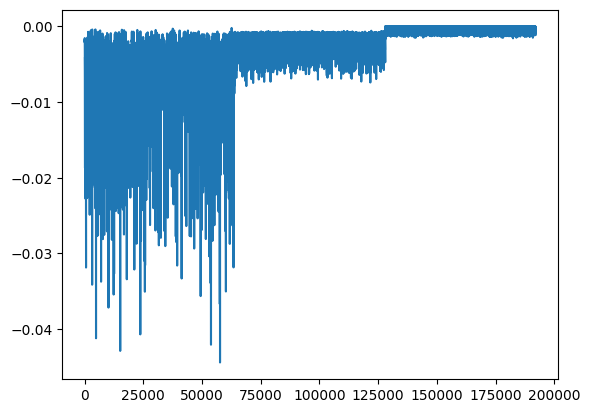

In [88]:
# Init exp_pool
exp_pool = None
datas = reset(init_mjx_data, controller_batch_size*20)
keys = jax.random.split(key, controller_batch_size*20)
# datas = reset(init_mjx_data, 2)
# keys = jax.random.split(key, 2)
for i in range(3):
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    if(i>=0):
        exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)

#plot exp_pool
# plt.plot(exp_pool.states.T[1])
plt.plot(exp_pool.rewards)
# plt.plot(exp_pool.states[0])

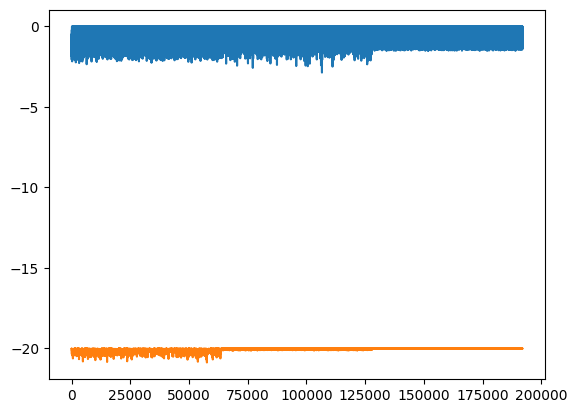

In [89]:
# print(exp_pool.states)
plt.plot(v_criticer(critic_params ,exp_pool.states))
plt.plot(exp_pool.rewards*20-20)

---------- 0 ----------
criticer loss: 0.0032217836
Controller Loss: 11.388113
mean rewards: -0.0062845447
mean score: -0.28813487
scorc/reward: 45.848167
death rate: 0.001875
best_death_rate: 0.001875
---------- 1 ----------
criticer loss: 0.0024338937
Controller Loss: 4.0304346
mean rewards: -0.0071686804
mean score: -0.103270024
scorc/reward: 14.405724
death rate: 0.00328125
best_death_rate: 0.001875
---------- 2 ----------
criticer loss: 0.0021992454
Controller Loss: 3.9058764
mean rewards: -0.0072759106
mean score: -0.097398676
scorc/reward: 13.386457
death rate: 0.0033333332
best_death_rate: 0.001875
---------- 3 ----------
criticer loss: 0.002091652
Controller Loss: 1.9983943
mean rewards: -0.0250428
mean score: -0.05046196
scorc/reward: 2.0150287
death rate: 0.010703124
best_death_rate: 0.001875
---------- 4 ----------
criticer loss: 0.0018052611
Controller Loss: 2.109446
mean rewards: -0.004407127
mean score: -0.05412957
scorc/reward: 12.282281
death rate: 0.0085625
best_death

/tmp/ipykernel_894762/2515454010.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Controller Loss: 375.85254
mean rewards: -0.07189255
mean score: -9.575786
scorc/reward: 133.1958
death rate: 0.13995625
best_death_rate: 0.001875
---------- 402 ----------
criticer loss: 0.09293517
Controller Loss: 416.40424
mean rewards: -0.08517855
mean score: -10.589819
scorc/reward: 124.32496
death rate: 0.13884374
best_death_rate: 0.001875
---------- 403 ----------
criticer loss: 0.0861816
Controller Loss: 431.60742
mean rewards: -0.10273865
mean score: -10.991042
scorc/reward: 106.9806
death rate: 0.13989374
best_death_rate: 0.001875
---------- 404 ----------
criticer loss: 0.08286249
Controller Loss: 395.7398
mean rewards: -0.0626853
mean score: -10.100599
scorc/reward: 161.13185
death rate: 0.13892499
best_death_rate: 0.001875
---------- 405 ----------
criticer loss: 0.0851313
Controller Loss: 405.60257
mean rewards: -0.0700015
mean score: -10.363618
scorc/reward: 148.04852
death rate: 0.1369125
best_death_rate: 0.001875
---------- 406 ----------
criticer loss: 0.102708735
Con

KeyboardInterrupt: 

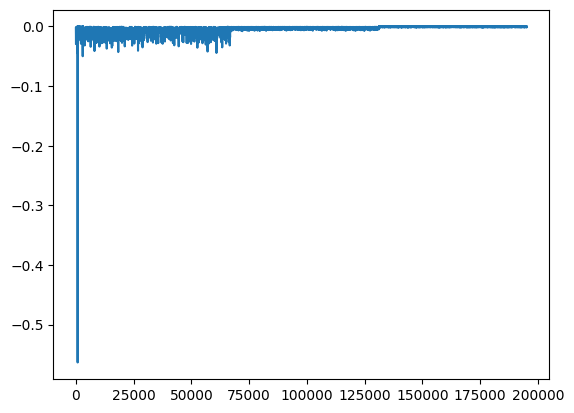

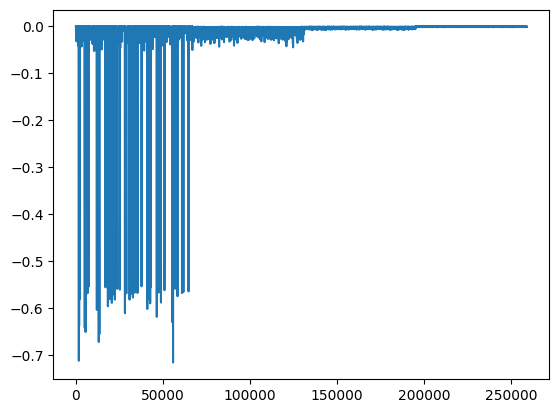

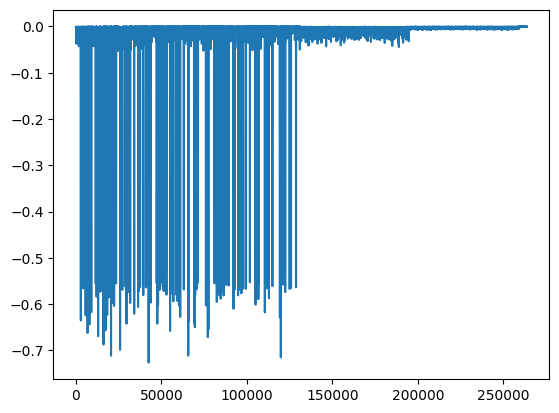

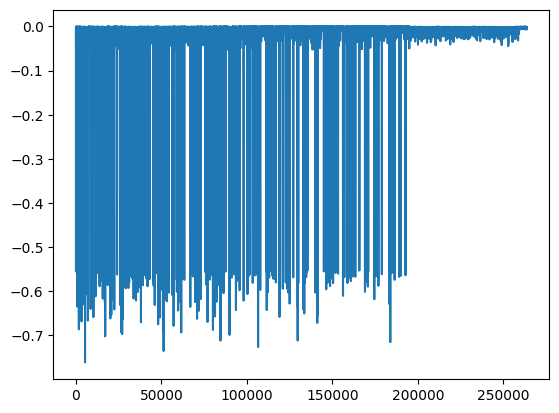

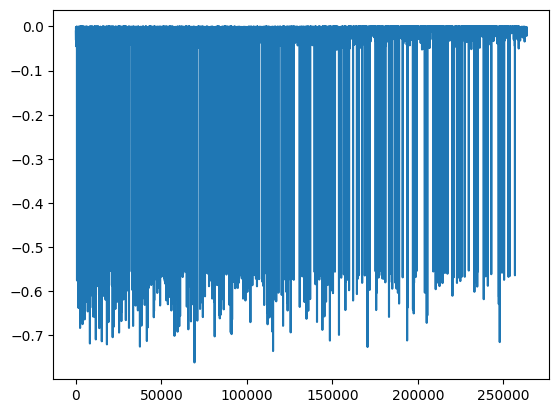

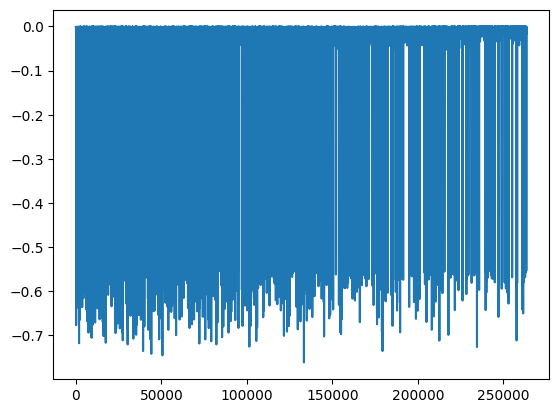

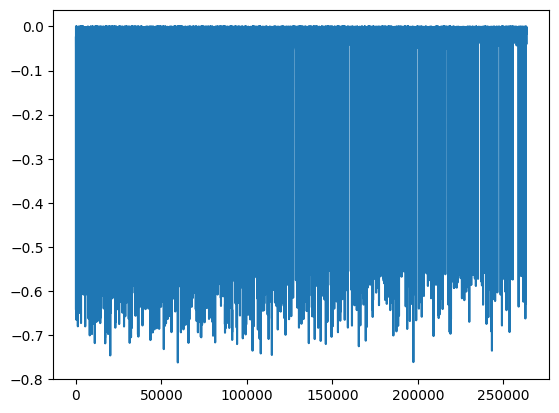

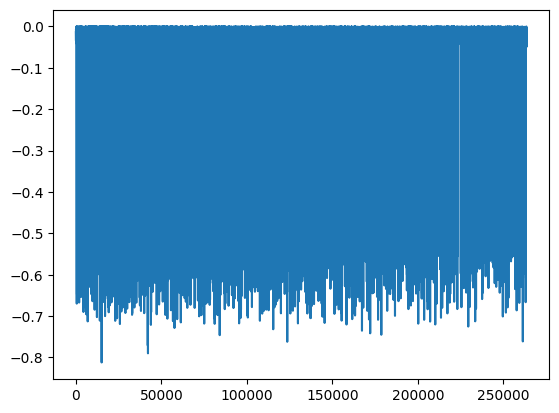

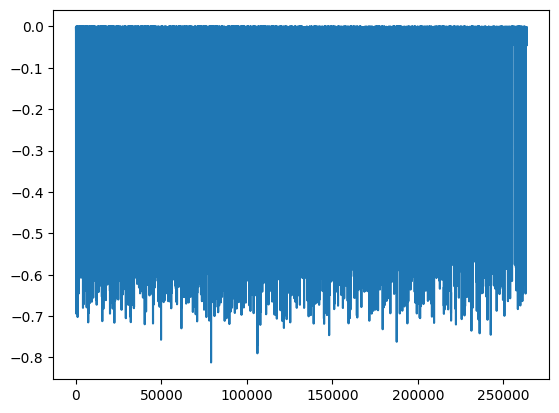

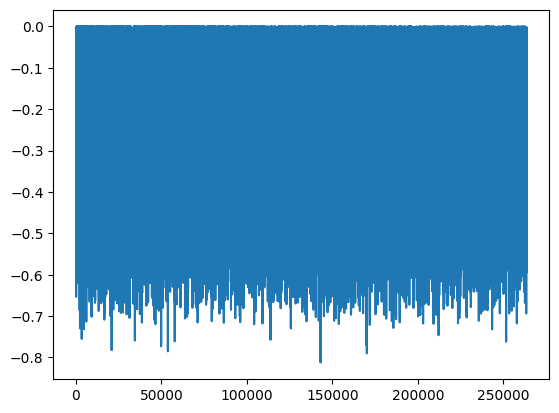

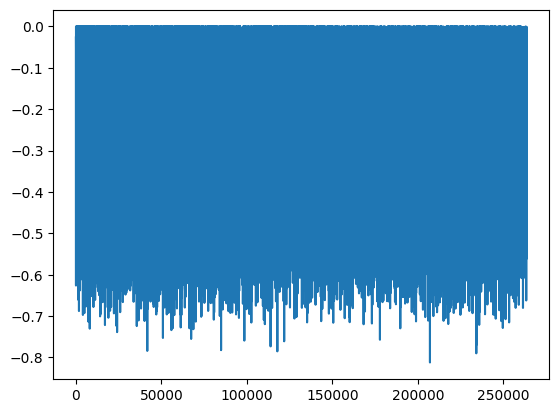

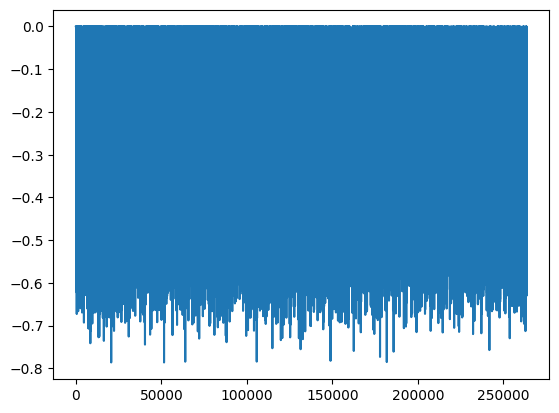

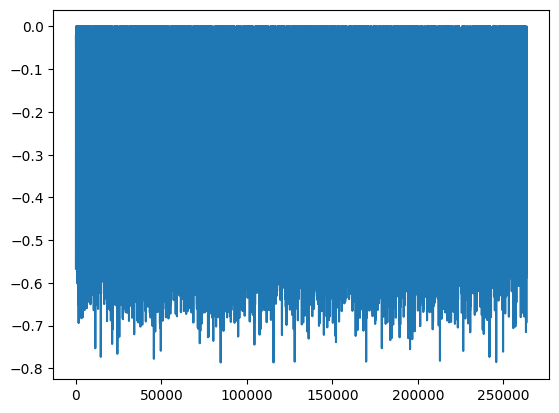

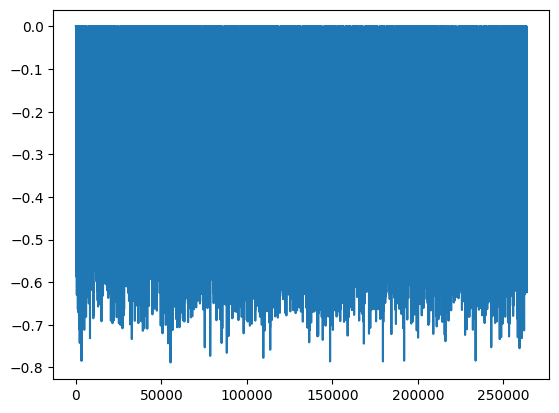

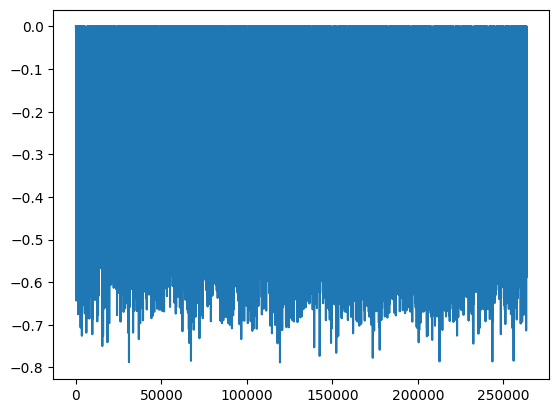

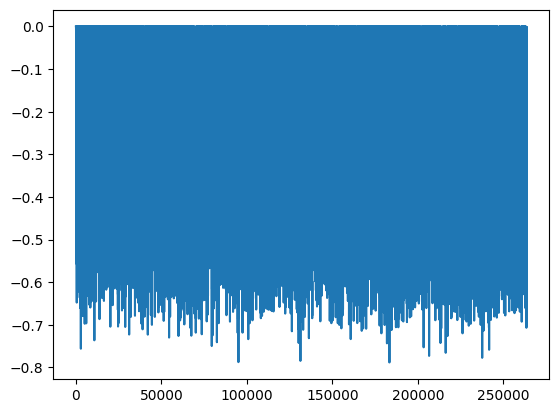

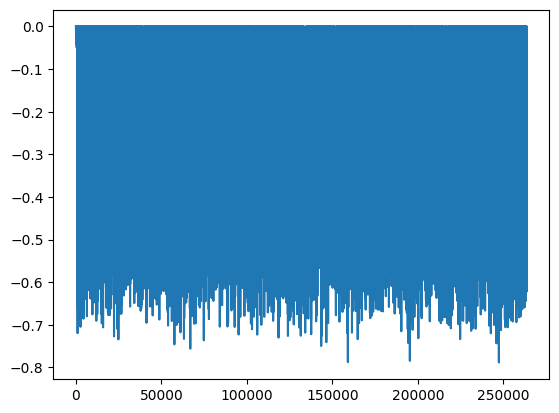

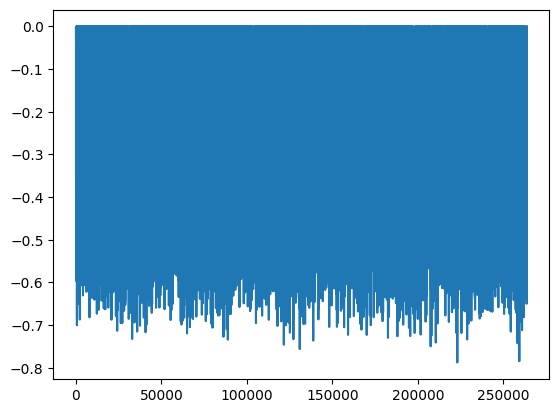

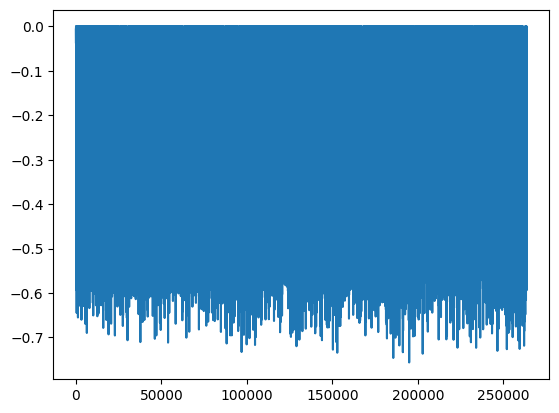

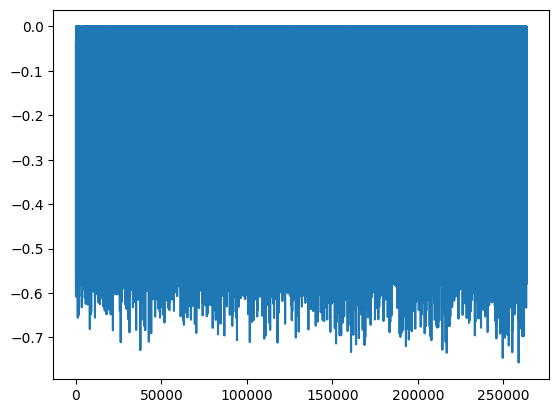

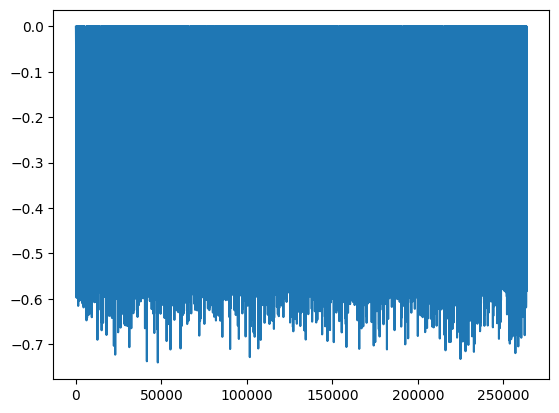

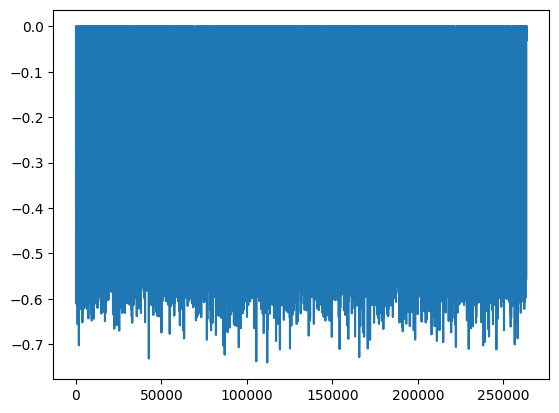

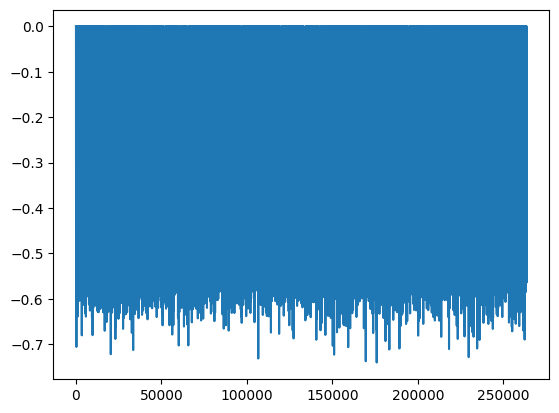

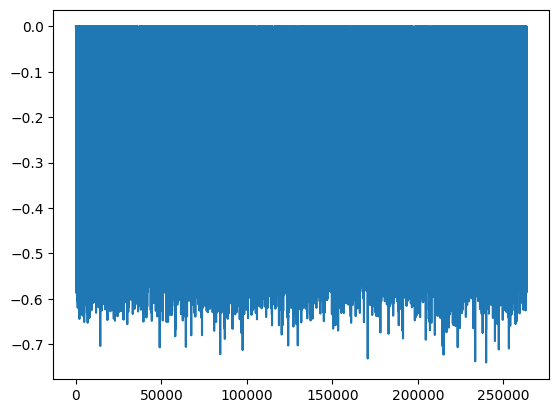

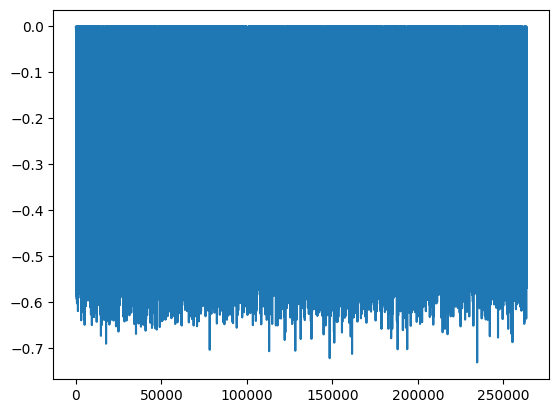

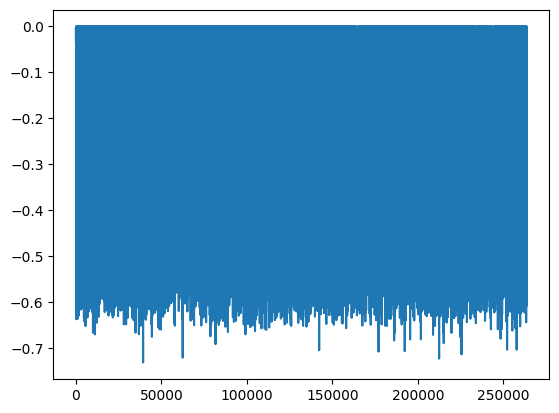

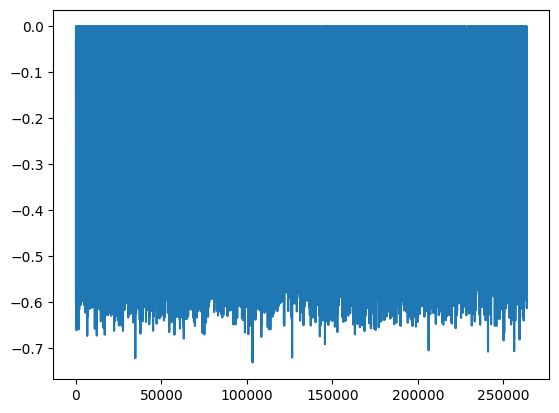

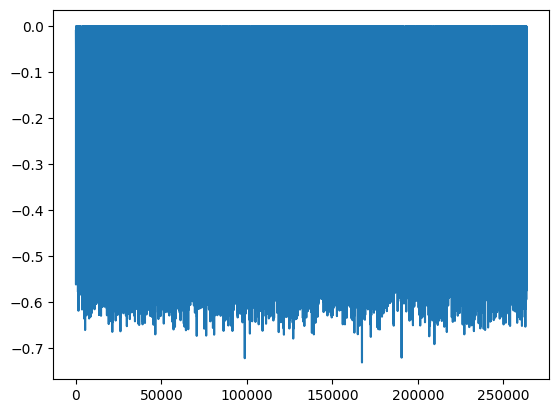

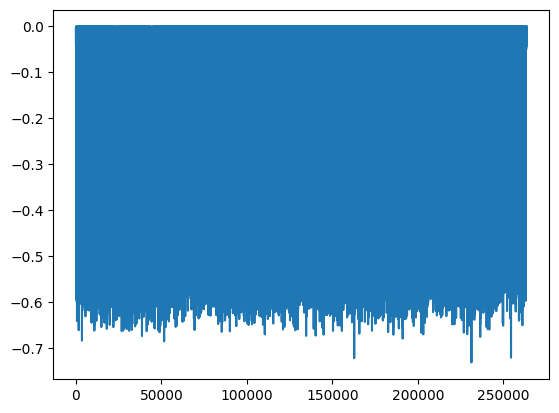

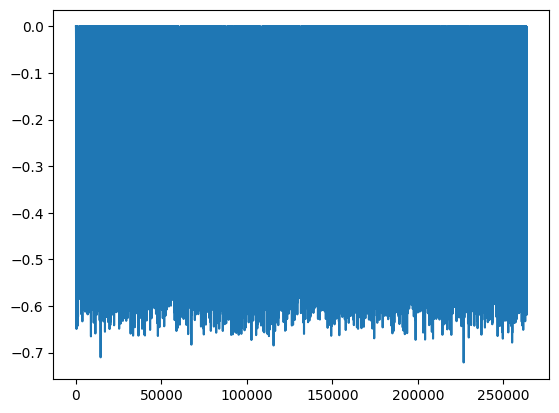

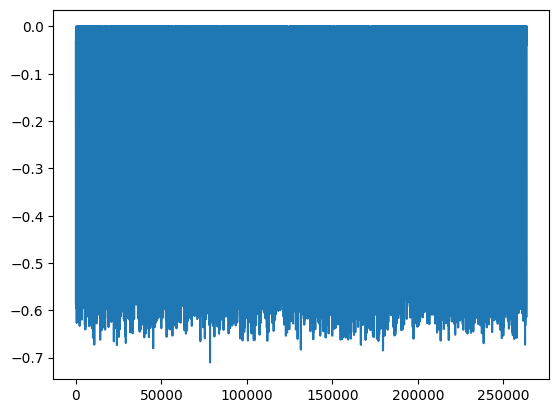

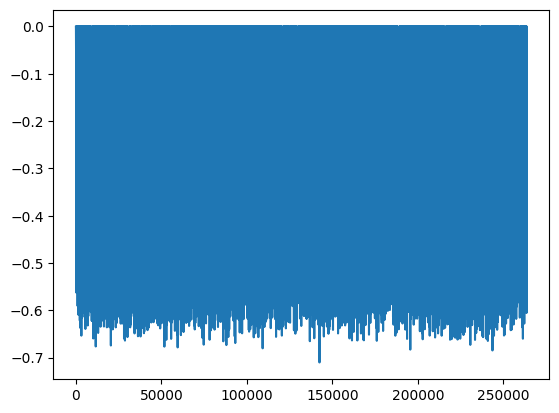

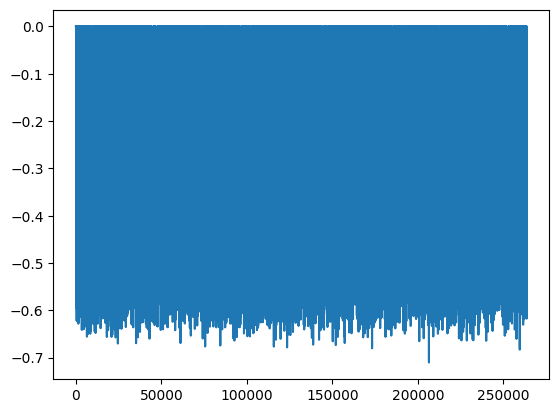

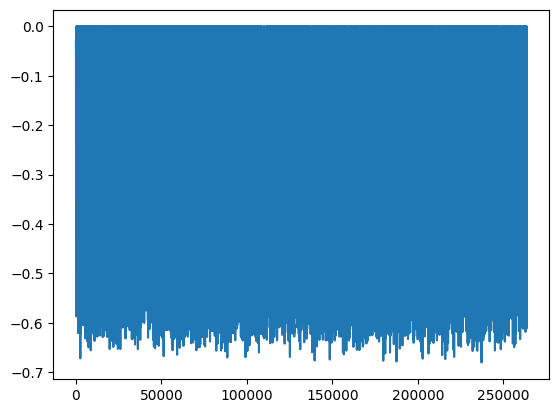

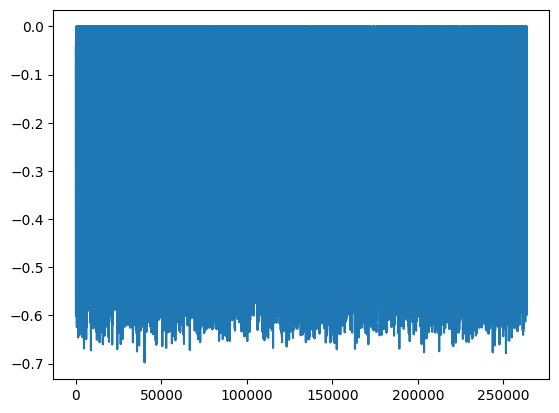

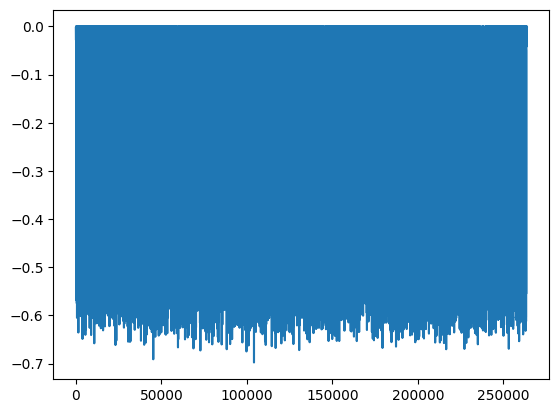

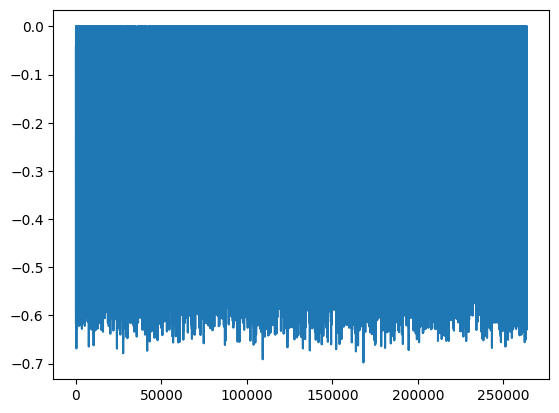

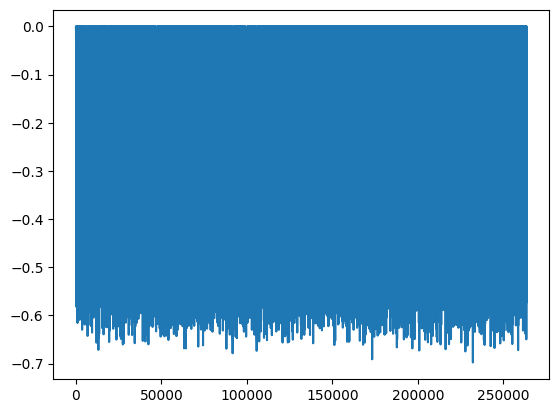

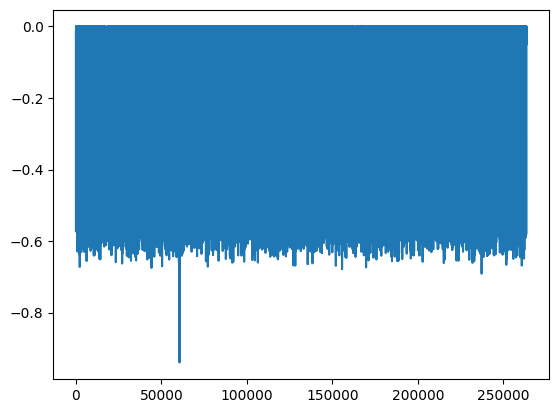

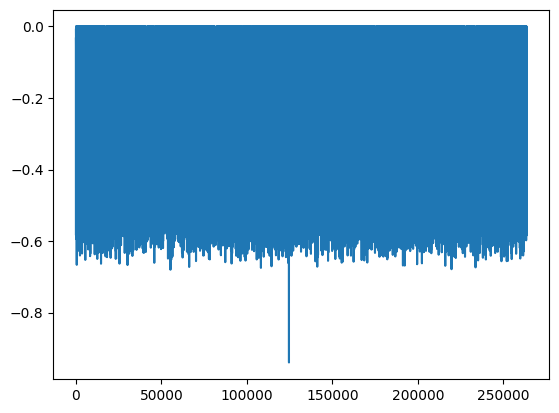

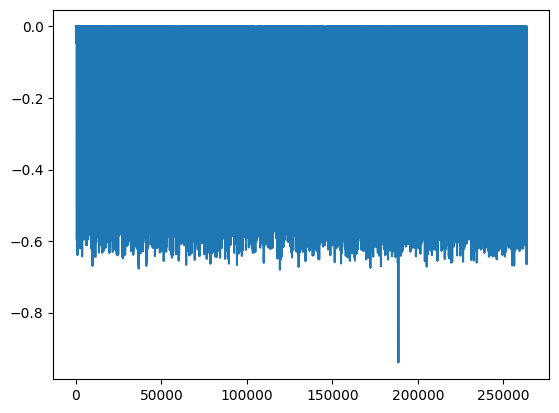

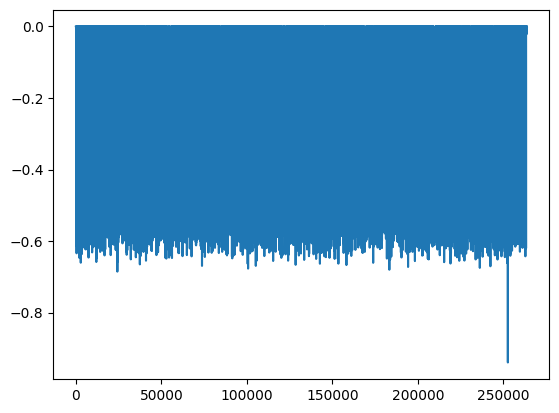

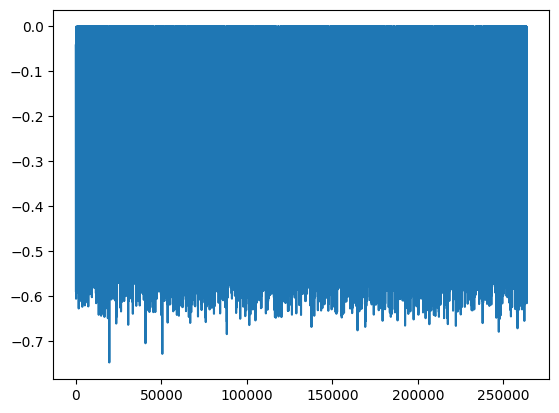

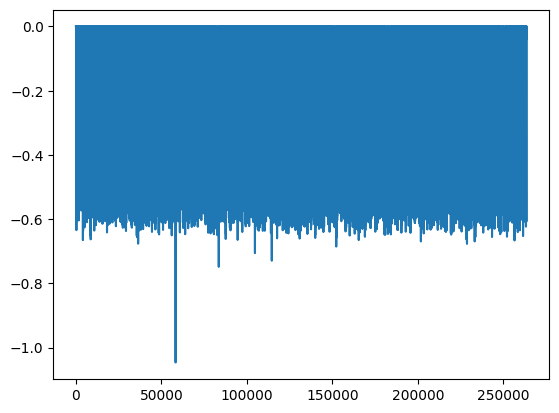

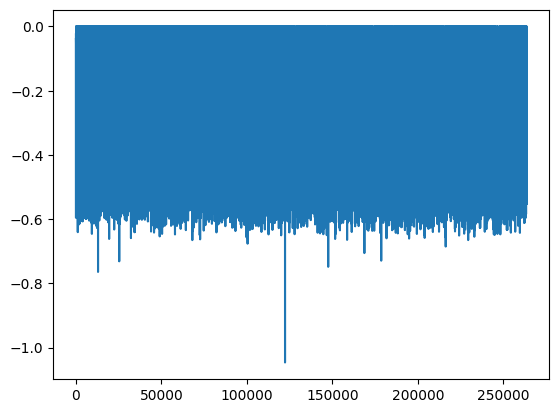

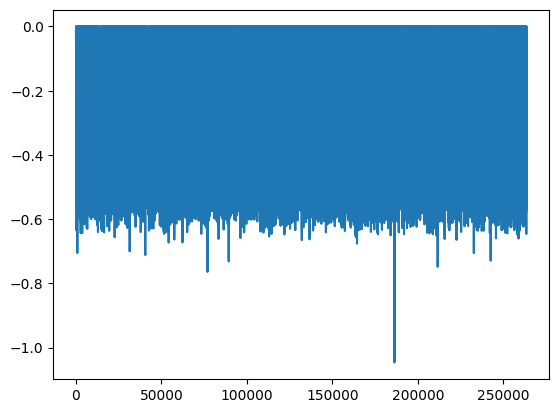

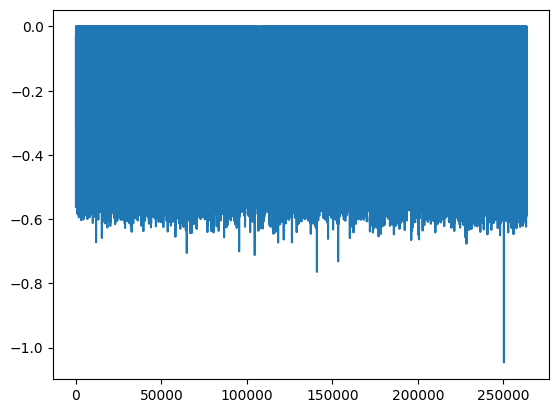

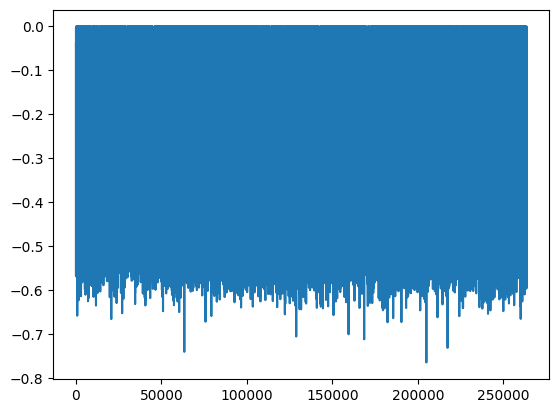

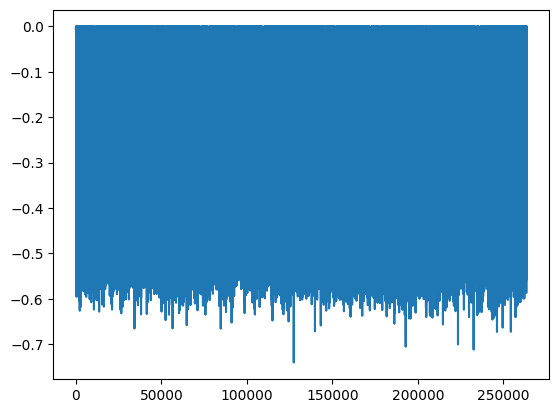

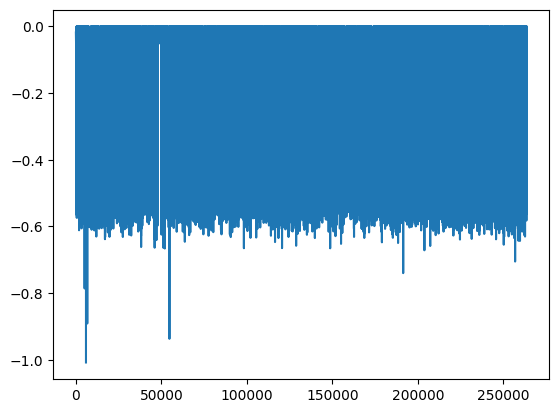

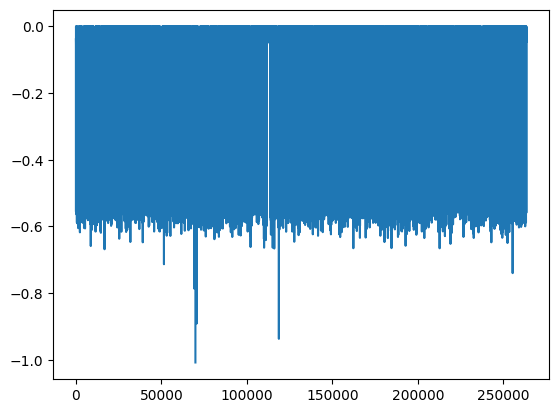

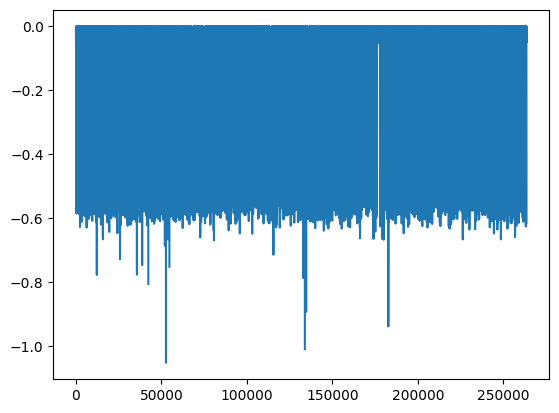

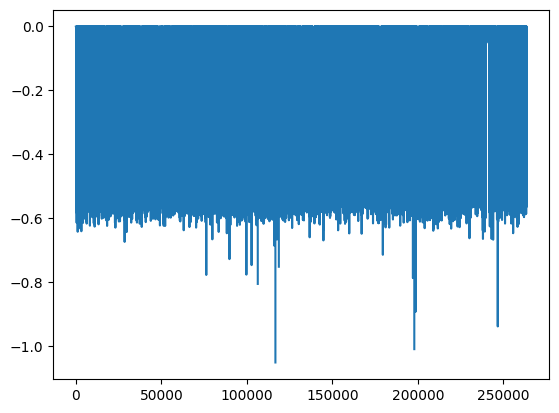

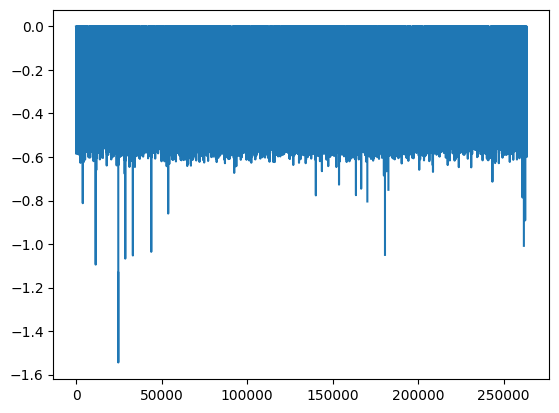

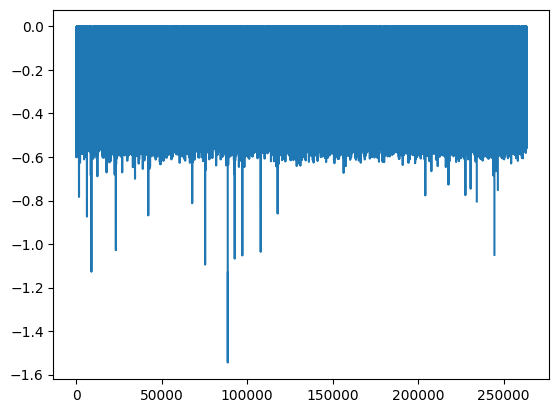

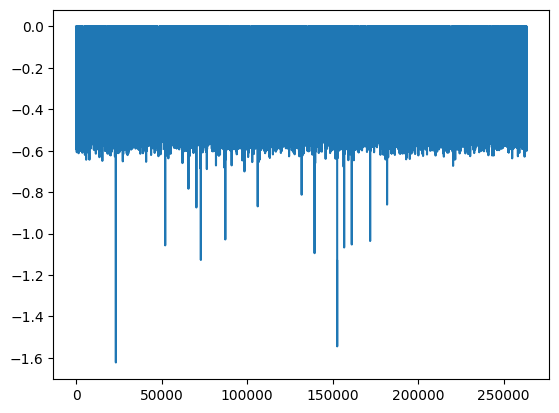

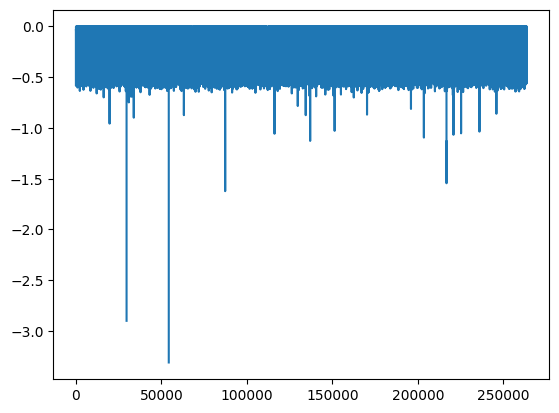

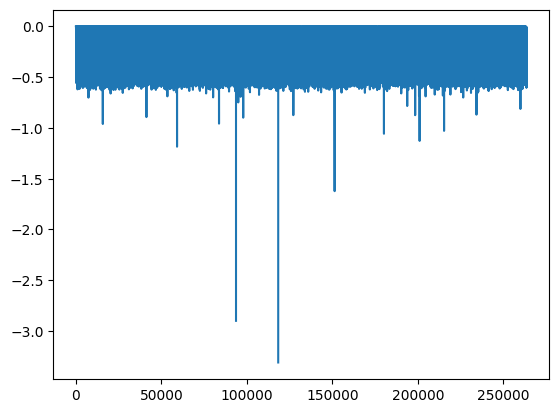

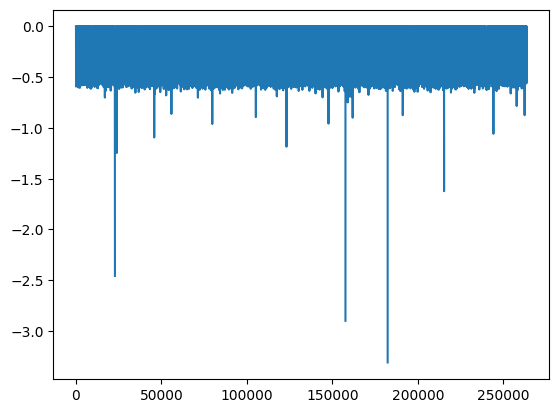

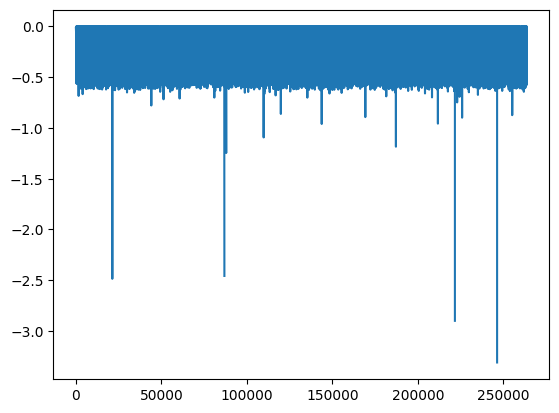

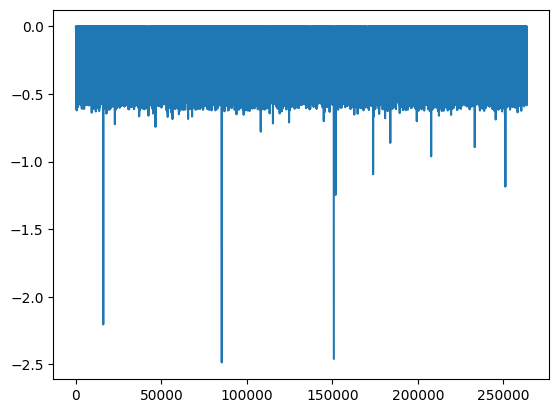

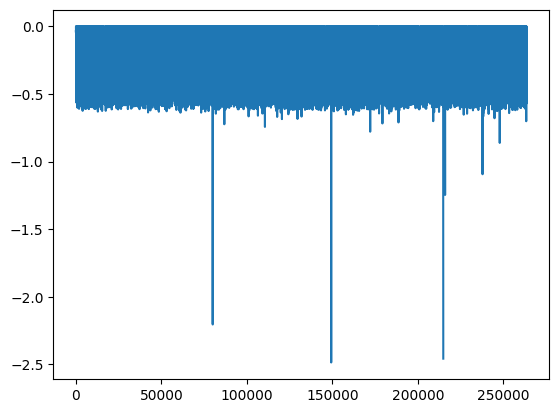

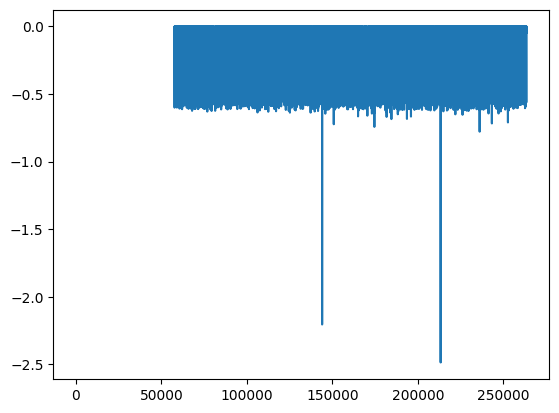

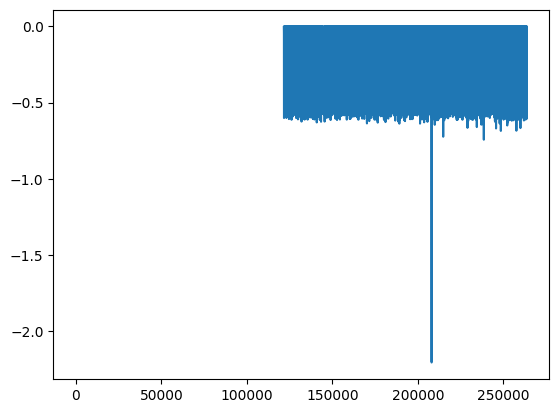

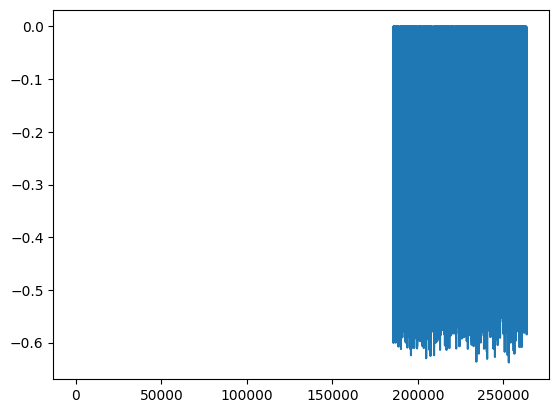

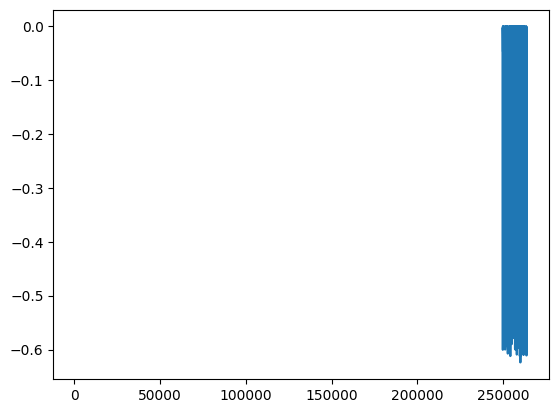

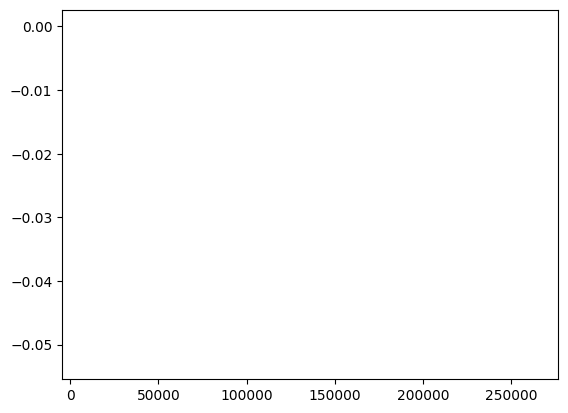

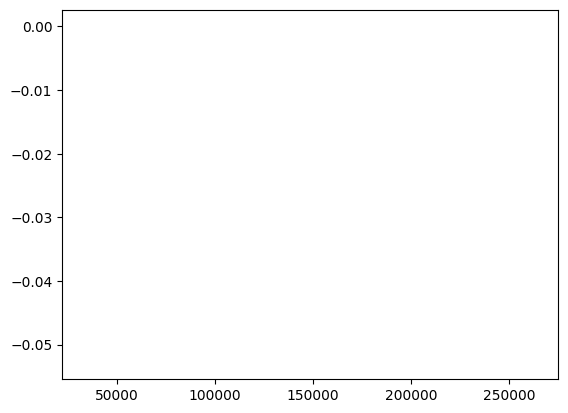

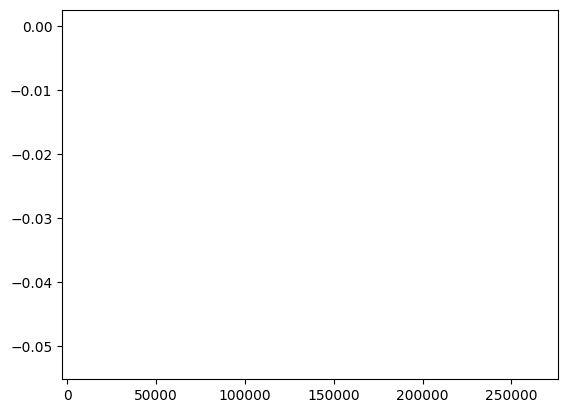

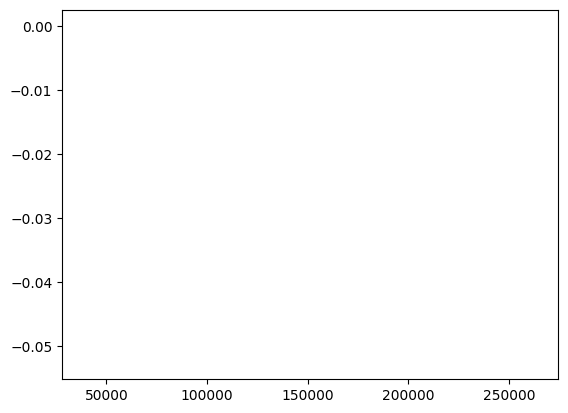

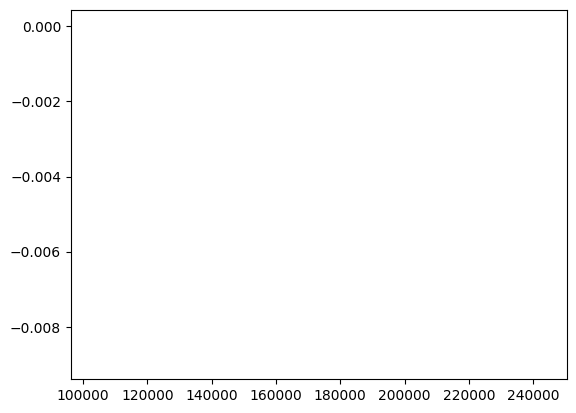

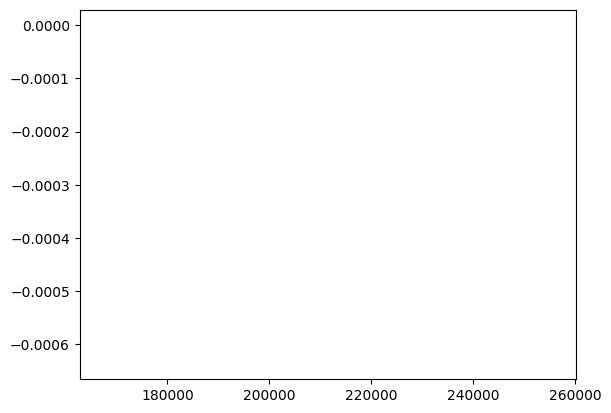

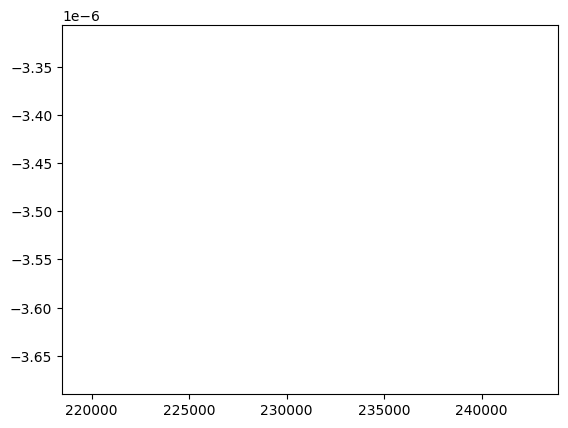

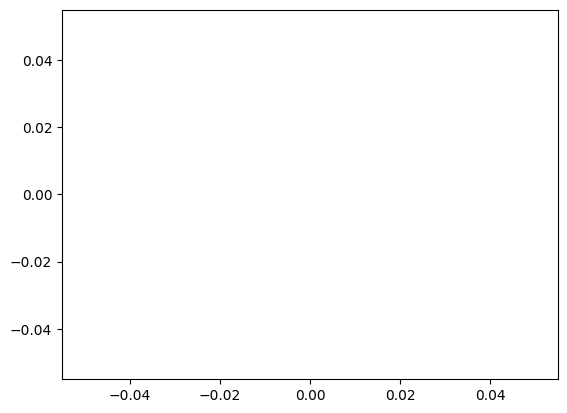

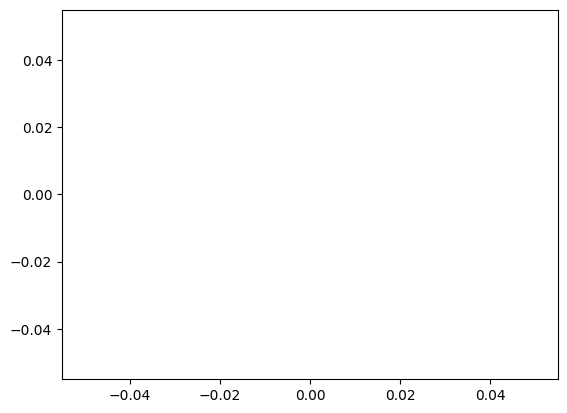

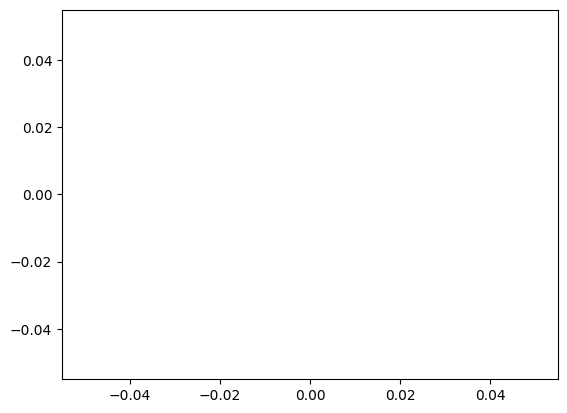

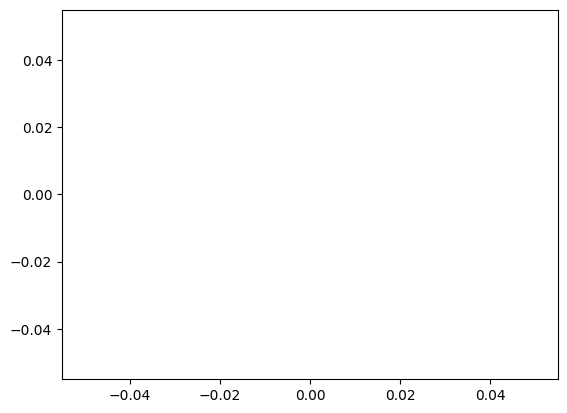

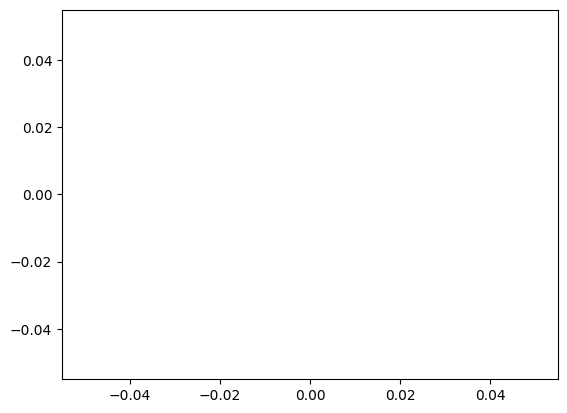

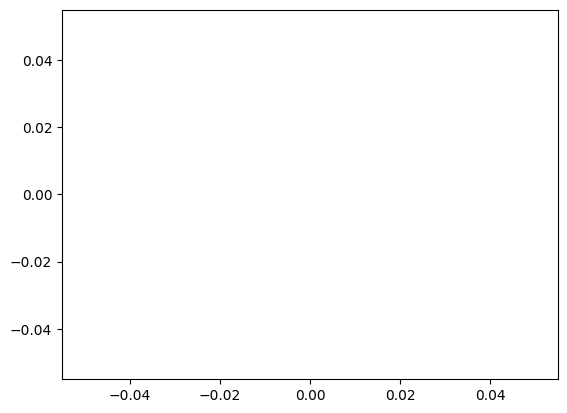

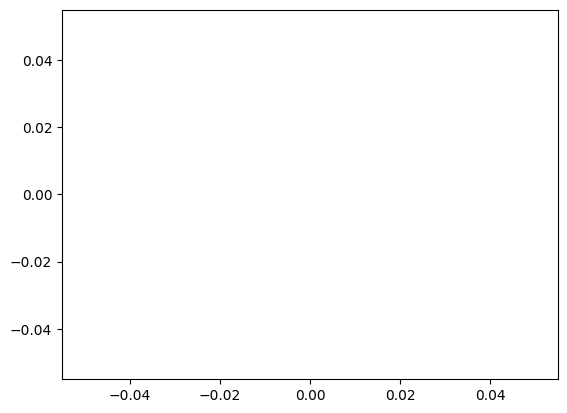

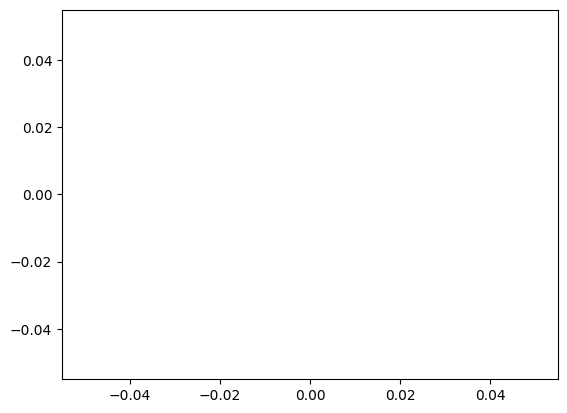

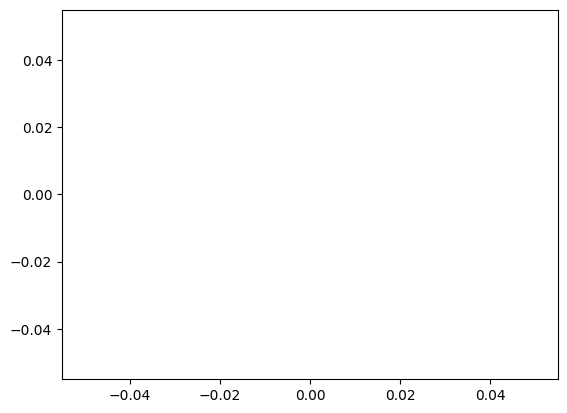

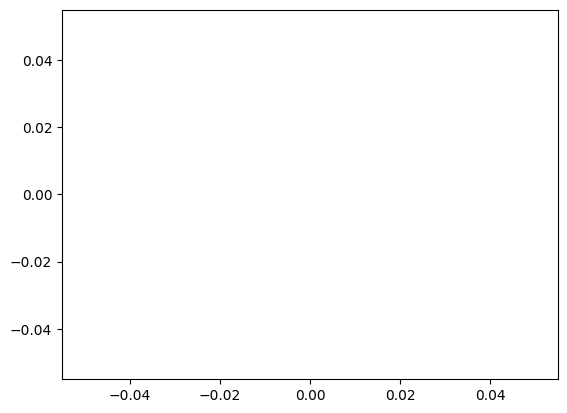

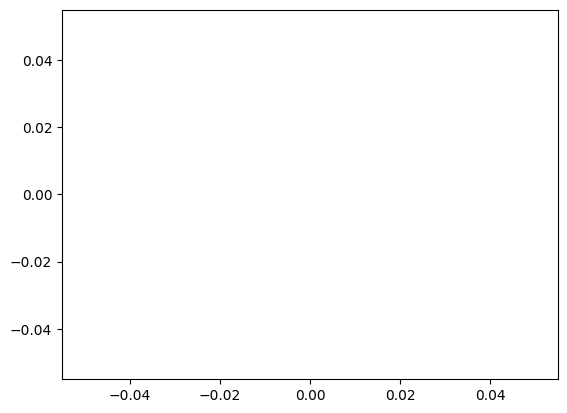

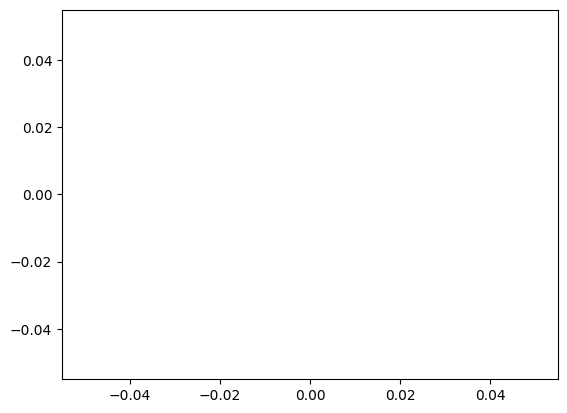

In [90]:
# Debug Nan
# jax.config.update("jax_debug_nans", True)

import exp


death_rate_buf = []
best_death_rate = 0.5

for i in range(4000):

    print("----------",i,"----------")
    criric_repeat = 40
    if(i >= 200):
        criric_repeat = 1
        
    for j in range(criric_repeat):
        batch = jit_sample(exp_pool, critic_batch_size, key)
        key = jax.random.split(key, 1)[0]
        
        # criticer
        critic_loss, critic_loss_grad = jit_critic_loss_g_value(critic_params, batch)
        
        # Update params
        critic_updates, critic_opt_state = jit_critic_tx_update(critic_loss_grad, critic_opt_state)
        critic_params = jit_apply_update(critic_params, critic_updates)
    
    print("criticer loss:",critic_loss)
    # controller
    
    controller_repeat = 1
    # if(i >= 10):
        # controller_repeat = 5
    
    for j in range(controller_repeat):
        keys = jax.random.split(key,controller_batch_size)
        controller_batch = jit_sample(exp_pool, controller_batch_size, key)
        key = jax.random.split(key, 1)[0]
        controller_loss_exps, controller_loss_grad = jit_g_loss_experience(
            controller_params, critic_params, controller_batch, mjx_model, init_data_batch, keys)
        controller_loss = controller_loss_exps[0]
        exps = controller_loss_exps[1]
            
        # Update params
        controller_updates, controller_opt_state = jit_controller_tx_update(controller_loss_grad, controller_opt_state)
        controller_params = jit_apply_update(controller_params, controller_updates)
    
    exp_pool = jit_add_exp(memory_settings, exp_pool, exps)
    
    # Count Dones
    death_rate_buf.insert(0, jp.count_nonzero( exps.dones)/(exps.dones.shape[1]*controller_batch_size))
    death_rate_buf = death_rate_buf[:50]
    death_rate = np.mean(death_rate_buf)
    
    print("Controller Loss:", controller_loss)
    mean_reward = jp.mean(exps.rewards)
    print("mean rewards:", mean_reward)
    mean_score = jp.mean(jit_v_criticer(critic_params, exps.states))
    print("mean score:", mean_score)
    print("scorc/reward:", mean_score/mean_reward)
    print("death rate:", death_rate)
    
    if(best_death_rate > death_rate): best_death_rate = death_rate
    print("best_death_rate:", best_death_rate)
    # add exps
    
    if(i%20 == 0):
        plt.figure()
        plt.plot(exp_pool.rewards)
        plt.plot()
        # plt.plot(exp_pool.rewards)

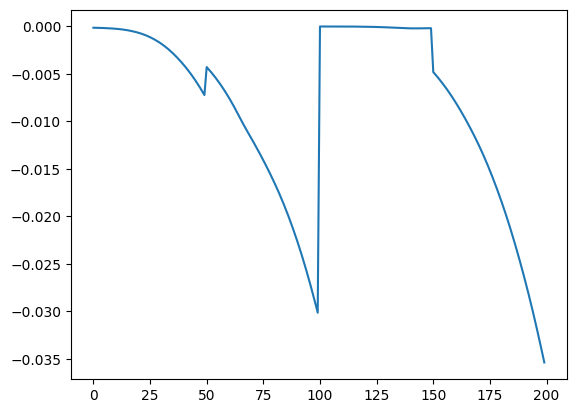

In [82]:
plt.plot(exp_pool.rewards[2000:2200])

## Visualize the model and controller

In [83]:
import mujoco.viewer
import time


# Disable tendon
opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)

previous_frame_time = time.time()
i = 0
key = jax.random.key(334)
with mujoco.viewer.launch_passive(mj_model, mj_data) as viewer:
    while viewer.is_running():
        # Update mjx_data from mj_data. The mj_data was modified by the viewer
        # mjx_data = mjx_data.replace(ctrl=mj_data.ctrl, xfrc_applied=mj_data.xfrc_applied)
        # Use the nerual network to generate ctrl signal
        
        mjx_data = mjx_data.replace(xfrc_applied=jp.array(mj_data.xfrc_applied, dtype=jp.float32))
        
        # Generate key
        key = jax.random.split(key,1)[0]
        # xfrc = jax.random.uniform(key,(mjx_model.nbody, 6), minval=-10, maxval=10)
        # mjx_data = mjx_data.replace(xfrc_applied=xfrc)
        mjx_data = mjx_data.replace(
            qpos= jp.array(mj_data.qpos, dtype=jp.float32),
            qvel= jp.array(mj_data.qvel, dtype=jp.float32),
            time = jp.array(mj_data.time, dtype=jp.float32))
        
        # Update mjx_model from mj_model
        mjx_model = mjx_model.tree_replace({
            'opt.gravity': jp.array(mj_model.opt.gravity, dtype=jp.float32),
            'opt.tolerance': jp.array(mj_model.opt.tolerance, dtype=jp.float32),
            'opt.ls_tolerance': jp.array(mj_model.opt.ls_tolerance, dtype=jp.float32),
            'opt.timestep': jp.array(mj_model.opt.timestep, dtype=jp.float32),
        })
        
        # mjx_data = mjx_step(mjx_model, mjx_data)
        # mjx_data, loss, exps = jit_nn_multi_steps(controller_params, mjx_model, mjx_data, key)
        mjx_data, key, act = jit_nn_mjx_one_step_no_random(controller_params, mjx_model, mjx_data, key)
        mjx.get_data_into(mj_data, mj_model, mjx_data)
        
        # Record the current time at the start of this frame
        current_frame_time = time.time()
    
        # Calculate the difference in time from the last frame
        time_between_frames = current_frame_time - previous_frame_time
    
        # Print the time between frames
        print(f"Time between frames: {time_between_frames} seconds")
        previous_frame_time = current_frame_time
        
        # print("ACT:", mjx_data.biomtu.act)
        # print(mjx_data.qpos)
        # print(mj_data.sen)  
        print(mjx_data.sensordata[2])
        print(mjx_data.biomtu.act)
        # print(len(mjx_data.qvel))
        viewer.sync()

Time between frames: 0.27612829208374023 seconds
1.6315
[0.     0.     0.     0.9434 0.2171 1.4019 2.1068 0.     1.5436 0.913  0.3061 0.5201 0.     0.
 0.     0.     0.     0.     0.     0.     2.2835 0.7531 0.     0.     0.8362 0.5291 0.     1.5996
 0.     1.3788 0.     0.3345 0.     0.     0.8738 1.4696 0.7744 1.3717 0.     0.4901 0.     0.
 0.0857 0.     0.6086 0.     0.     0.     0.     1.2005 0.4367 0.     0.     0.0965]
Time between frames: 0.019269227981567383 seconds
1.6315138
[0.3735 0.3285 0.6064 0.     1.3651 1.5641 3.9478 0.     1.0741 2.0036 2.7137 0.9679 1.8086 0.
 0.     0.     0.     1.9254 0.     1.6798 0.     0.     0.     0.     3.2009 2.1223 0.0948 1.2627
 0.2498 0.0307 0.     1.3477 0.     0.9274 0.     0.     0.3112 0.     0.     0.0824 0.     0.4497
 1.4602 0.     0.338  1.2656 0.5585 0.     0.     0.1992 0.2511 0.     0.     0.9967]
Time between frames: 0.01468801498413086 seconds
1.6315238
[0.1903 0.     0.6843 0.     0.623  1.3791 2.3084 0.     1.0687 0.     